In [1]:
from typing import List

import ray
import torch
import torch.optim as optim
from ml_collections import config_dict
from ray import tune, air
from ray.air import session, Checkpoint
from ray.tune.schedulers import PopulationBasedTraining
from torch import nn
from torch.nn import functional as F

In [2]:
def get_config():
    config = config_dict.ConfigDict()
    # General parameters
    config.dataset = 'Organoid'
    config.model = 'VAE'
    config.seed = 12345
    config.output_dir = './logs/VanillaVAE/'
    config.device = 'cuda'
    config.epochs = 10000

    # VAE architecture parameters
    config.architecture = config_dict.ConfigDict()
    config.architecture.in_features = 41
    config.architecture.latent_dim = 2
    config.architecture.hidden_dims = (32, 32, 32)
    config.architecture.kld_weight = 0.0025
    config.architecture.loss_type = 'beta'
    config.architecture.activation = 'GELU'

    # Tunable parameters
    config.tunable = config_dict.ConfigDict()
    config.tunable.learning_rate = 0.05
    config.tunable.weight_decay = 0.0
    config.tunable.batch_size = 4096
    return config

In [3]:
class BetaVAE(nn.Module):

    def __init__(self, config: config_dict.ConfigDict) -> None:
        super(BetaVAE, self).__init__()

        self.config = config
        self.kld_weight = torch.Tensor([config.architecture.kld_weight]).to(config.device)

        self.act_class = getattr(nn, config.architecture.activation)

        modules = []

        # Build Encoder

        encoder_dims = [config.architecture.in_features] + list(config.architecture.hidden_dims)

        for i in range(len(config.architecture.hidden_dims)):
            modules.append(
                nn.Sequential(
                    nn.Linear(in_features=encoder_dims[i], out_features=encoder_dims[i + 1]),
                    nn.BatchNorm1d(encoder_dims[i + 1]),
                    self.act_class(),
                )
            )
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config.architecture.hidden_dims[-1], config.architecture.latent_dim)
        self.fc_var = nn.Linear(config.architecture.hidden_dims[-1], config.architecture.latent_dim)

        # Build Decoder
        modules = []
        decoder_dims = [config.architecture.latent_dim] + list(reversed(config.architecture.hidden_dims)) + [config.architecture.in_features]

        for i in range(len(config.architecture.hidden_dims) + 1):
            modules.append(
                nn.Sequential(
                    nn.Linear(decoder_dims[i], decoder_dims[i + 1]),
                    nn.BatchNorm1d(decoder_dims[i + 1]),
                    self.act_class()
                )
            )

        self.decoder = nn.Sequential(*modules)
        self.final_layer = nn.Linear(config.architecture.in_features, config.architecture.in_features)

    def encode(self, input: torch.Tensor) -> List[torch.Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """
        Maps the given latent codes
        onto the sample matrix space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C]
        """
        # Only batch - normalized layers
        result = self.decoder(z)
        # Use linear layer to map normalized decoder outputs back to input space
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: torch.Tensor) -> List[torch.Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args) -> dict:
        r"""
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param epoch: current epoch
        :param args:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        recons_loss = F.mse_loss(recons, input)

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim=1), dim=0)

        loss = recons_loss + self.kld_weight * kld_loss

        return {'loss': loss, 'MSE': recons_loss.detach(), 'KLD': -kld_loss.detach()}

    def generate(self, x: torch.Tensor) -> torch.Tensor:
        """
        Given an input sample matrix x, returns the reconstructed sample matrix
        :param x: (Tensor) [B x C]
        :return: (Tensor) [B x C]
        """

        return self.forward(x)[0]

    def latent(self, x: torch.Tensor) -> torch.Tensor:
        return self.reparameterize(*self.encode(x))

In [19]:
from datasets import OrganoidDataset

data = OrganoidDataset()

X_train, y_train = data.train
X_val, y_val = data.val
config = get_config()
X_train_batches = torch.split(X_train, split_size_or_sections=config.tunable.batch_size)
X_val_batches = torch.split(X_val, split_size_or_sections=config.tunable.batch_size)

In [5]:
X_train_batches[0].shape

torch.Size([4096, 41])

In [6]:
model = BetaVAE(config).to(config.device)

In [7]:
model.loss_function(*model.forward(X_train_batches[0]))

{'loss': tensor([6.0899], device='cuda:0', grad_fn=<AddBackward0>),
 'MSE': tensor(6.0893, device='cuda:0'),
 'KLD': tensor(-0.2448, device='cuda:0')}

In [9]:
def train(model,optimizer,train_dataloader):
    for X_batch in train_dataloader:
        optimizer.zero_grad()
        model.train()
        outputs = model.forward(X_batch)
        loss = model.loss_function(*outputs)

        loss['loss'].backward()
        optimizer.step()

In [10]:
def test(model,val_dataloader):
    with torch.no_grad():
        model.eval()
        mse,kld,loss = list(),list(),list()
        for X_batch in val_dataloader:
            loss_dict = dict()
            outputs = model.forward(X_batch)
            losses = model.loss_function(*outputs)
            for key in losses.keys():
                loss_dict[key] = losses[key].item() * X_batch.shape[0]
            mse.append(loss_dict['MSE'])
            kld.append(loss_dict['KLD'])
            loss.append(loss_dict['loss'])
    data_len = sum(len(batch) for batch in val_dataloader)
    return sum(mse)/data_len,sum(kld)/data_len, sum(loss)/data_len


In [11]:
model = BetaVAE(config).to(config.device)

In [12]:
optimizer = optim.Adam(model.parameters(),
                        lr=config.get("learning_rate", 0.05),
                        weight_decay=config.get("weight_decay", 0.0),
                        )

In [21]:
train(model,optimizer,X_train_batches)

In [22]:
test(model,X_val_batches)

(0.47315053030962567, -6.747065047704933, 0.4900181938554461)

In [23]:
def vae_train(cfg):
    config = cfg.get('default_config')
    model = BetaVAE(config).to(config.device)

    optimizer = optim.Adam(model.parameters(),
                           lr=config.get("learning_rate", 0.05),
                           weight_decay=config.get("weight_decay", 0.0),
                           )

    dataset = OrganoidDataset(data_dir='/data/PycharmProjects/cytof_benchmark/data/organoids')
    X_train, y_train = dataset.train
    X_val, y_val = dataset.val
    X_train_batches = torch.split(X_train, split_size_or_sections=config.get("batch_size", 16384))
    X_val_batches = torch.split(X_val, split_size_or_sections=config.get("batch_size", 16384))

    step = 1
    if session.get_checkpoint():
        checkpoint_dict = session.get_checkpoint().to_dict()

        model.load_state_dict(checkpoint_dict["model"])
        optimizer.load_state_dict(checkpoint_dict["optim"])
        # Note: Make sure to increment the loaded step by 1 to get the
        # current step.
        last_step = checkpoint_dict["step"]
        step = last_step + 1

        # NOTE: It's important to set the optimizer learning rates
        # again, since we want to explore the parameters passed in by PBT.
        # Without this, we would continue using the exact same
        # configuration as the trial whose checkpoint we are exploiting.
        if "learning_rate" in cfg:
            for param_group in optimizer.param_groups:
                param_group["lr"] = cfg["learning_rate"]
        if "weight_decay" in cfg:
            for param_group in optimizer.param_groups:
                param_group["weight_decay"] = cfg["weight_decay"]
        print(cfg)
    while True:
        train(model,optimizer,X_train_batches)
        MSE, KLD, loss = test(model,X_val_batches)

        checkpoint = None
        if step % cfg["checkpoint_interval"] == 0:
            checkpoint = Checkpoint.from_dict(
                {
                    "model": model.state_dict(),
                    "optim": optimizer.state_dict(),
                    "step": step,
                }
            )
        session.report(
            {
                "MSE": MSE,
                "KLD": KLD,
                "loss": loss,
                'lr':cfg.get("learning_rate", 0.05),
                'wd':cfg.get("weight_decay", 0.0)
            },
            checkpoint=checkpoint,
        )
        step += 1

In [24]:
ray.init()

2023-01-09 16:19:49,481	INFO worker.py:1538 -- Started a local Ray instance.


Python version:,3.10.6
Ray version:,2.2.0


In [28]:
perturbation_interval = 10
scheduler = PopulationBasedTraining(
    time_attr="time_total_s",
    perturbation_interval=perturbation_interval,
    hyperparam_mutations={
        # Distribution for resampling
        "learning_rate": tune.loguniform(1e-5, 1e-2),
        "weight_decay": tune.loguniform(1e-10, 1e-6),
        "batch_size":tune.randint(1024,16*1024)
    },
)

smoke_test = True  # For testing purposes: set this to False to run the full experiment
tuner = tune.Tuner(
    tune.with_resources(vae_train, {"cpu": 16, "gpu": 0.25}),
    run_config=air.RunConfig(
        name="vae_training",
        stop={"training_iteration": 1000},
        verbose=1,
    ),
    tune_config=tune.TuneConfig(
        metric="loss",
        mode="min",
        num_samples= 8,
        scheduler=scheduler,
    ),
    param_space={
        # Define how initial values of the learning rates should be chosen.
        "learning_rate": 1e-5,
        "weight_decay": 1e-9,
        "batch_size": 16384,
        "checkpoint_interval": perturbation_interval,
        "default_config":get_config()
    },
)
results_grid = tuner.fit()

2023-01-09 16:30:33,504	INFO pbt.py:646 -- [pbt]: no checkpoint for trial. Skip exploit for Trial vae_train_8645f_00004
2023-01-09 16:30:33,527	INFO pbt.py:646 -- [pbt]: no checkpoint for trial. Skip exploit for Trial vae_train_8645f_00001
2023-01-09 16:30:33,598	INFO pbt.py:646 -- [pbt]: no checkpoint for trial. Skip exploit for Trial vae_train_8645f_00007
2023-01-09 16:30:36,621	INFO pbt.py:646 -- [pbt]: no checkpoint for trial. Skip exploit for Trial vae_train_8645f_00002
2023-01-09 16:30:46,722	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00007 (score = -0.443788) into trial 8645f_00002 (score = -0.453924)

2023-01-09 16:30:46,723	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00002:
learning_rate : 1e-05 --- (* 0.8) --> 8.000000000000001e-06
weight_decay : 1e-09 --- (* 1.2) --> 1.2e-09
batch_size : 16384 --- (* 0.8) --> 13107

(vae_train pid=21785) 2023-01-09 16:30:47,586	INFO trainable.py:

(vae_train pid=21785) {'learning_rate': 8.000000000000001e-06, 'weight_decay': 1.2e-09, 'batch_size': 13107, 'checkpoint_interval': 10, 'default_config': architecture:
(vae_train pid=21785)   activation: GELU
(vae_train pid=21785)   hidden_dims: !!python/tuple
(vae_train pid=21785)   - 32
(vae_train pid=21785)   - 32
(vae_train pid=21785)   - 32
(vae_train pid=21785)   in_features: 41
(vae_train pid=21785)   kld_weight: 0.0025
(vae_train pid=21785)   latent_dim: 2
(vae_train pid=21785)   loss_type: beta
(vae_train pid=21785) dataset: Organoid
(vae_train pid=21785) device: cuda
(vae_train pid=21785) epochs: 10000
(vae_train pid=21785) model: VAE
(vae_train pid=21785) output_dir: ./logs/VanillaVAE/
(vae_train pid=21785) seed: 12345
(vae_train pid=21785) tunable:
(vae_train pid=21785)   batch_size: 4096
(vae_train pid=21785)   learning_rate: 0.05
(vae_train pid=21785)   weight_decay: 0.0
(vae_train pid=21785) }


2023-01-09 16:30:58,352	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00006 (score = -0.427840) into trial 8645f_00002 (score = -0.448313)

2023-01-09 16:30:58,354	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00002:
learning_rate : 1e-05 --- (resample) --> 1.1080714910059648e-05
weight_decay : 1e-09 --- (* 1.2) --> 1.2e-09
batch_size : 16384 --- (resample) --> 11851

(vae_train pid=23280) 2023-01-09 16:31:00,723	INFO trainable.py:790 -- Restored on 192.168.2.8 from checkpoint: /home/egor/ray_results/vae_training/vae_train_8645f_00002_2_2023-01-09_16-30-21/checkpoint_tmpa03d74
(vae_train pid=23280) 2023-01-09 16:31:00,723	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 55, '_timesteps_total': None, '_time_total': 31.296525955200195, '_episodes_total': None}


(vae_train pid=22933) {'learning_rate': 1e-05, 'weight_decay': 1e-09, 'batch_size': 16384, 'checkpoint_interval': 10, 'default_config': architecture:
(vae_train pid=22933)   activation: GELU
(vae_train pid=22933)   hidden_dims: !!python/tuple
(vae_train pid=22933)   - 32
(vae_train pid=22933)   - 32
(vae_train pid=22933)   - 32
(vae_train pid=22933)   in_features: 41
(vae_train pid=22933)   kld_weight: 0.0025
(vae_train pid=22933)   latent_dim: 2
(vae_train pid=22933)   loss_type: beta
(vae_train pid=22933) dataset: Organoid
(vae_train pid=22933) device: cuda
(vae_train pid=22933) epochs: 10000
(vae_train pid=22933) model: VAE
(vae_train pid=22933) output_dir: ./logs/VanillaVAE/
(vae_train pid=22933) seed: 12345
(vae_train pid=22933) tunable:
(vae_train pid=22933)   batch_size: 4096
(vae_train pid=22933)   learning_rate: 0.05
(vae_train pid=22933)   weight_decay: 0.0
(vae_train pid=22933) }
(vae_train pid=23105) {'learning_rate': 1.2e-05, 'weight_decay': 8.000000000000001e-10, 'batch_s

2023-01-09 16:31:13,275	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00001 (score = -0.418113) into trial 8645f_00005 (score = -0.436861)

2023-01-09 16:31:13,276	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00005:
learning_rate : 1e-05 --- (* 1.2) --> 1.2e-05
weight_decay : 1e-09 --- (* 0.8) --> 8.000000000000001e-10
batch_size : 16384 --- (* 0.8) --> 13107

(vae_train pid=23517) 2023-01-09 16:31:16,127	INFO trainable.py:790 -- Restored on 192.168.2.8 from checkpoint: /home/egor/ray_results/vae_training/vae_train_8645f_00005_5_2023-01-09_16-30-21/checkpoint_tmp5cf69b
(vae_train pid=23517) 2023-01-09 16:31:16,127	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 88, '_timesteps_total': None, '_time_total': 41.41149306297302, '_episodes_total': None}
2023-01-09 16:31:24,210	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00003 (score = -0.419265

(vae_train pid=23517) {'learning_rate': 1.2e-05, 'weight_decay': 8.000000000000001e-10, 'batch_size': 13107, 'checkpoint_interval': 10, 'default_config': architecture:
(vae_train pid=23517)   activation: GELU
(vae_train pid=23517)   hidden_dims: !!python/tuple
(vae_train pid=23517)   - 32
(vae_train pid=23517)   - 32
(vae_train pid=23517)   - 32
(vae_train pid=23517)   in_features: 41
(vae_train pid=23517)   kld_weight: 0.0025
(vae_train pid=23517)   latent_dim: 2
(vae_train pid=23517)   loss_type: beta
(vae_train pid=23517) dataset: Organoid
(vae_train pid=23517) device: cuda
(vae_train pid=23517) epochs: 10000
(vae_train pid=23517) model: VAE
(vae_train pid=23517) output_dir: ./logs/VanillaVAE/
(vae_train pid=23517) seed: 12345
(vae_train pid=23517) tunable:
(vae_train pid=23517)   batch_size: 4096
(vae_train pid=23517)   learning_rate: 0.05
(vae_train pid=23517)   weight_decay: 0.0
(vae_train pid=23517) }


2023-01-09 16:31:32,343	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00006 (score = -0.416475) into trial 8645f_00000 (score = -0.421663)

2023-01-09 16:31:32,344	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00000:
learning_rate : 1e-05 --- (* 0.8) --> 8.000000000000001e-06
weight_decay : 1e-09 --- (* 1.2) --> 1.2e-09
batch_size : 16384 --- (* 1.2) --> 19660



(vae_train pid=21777) {'learning_rate': 1.44e-05, 'weight_decay': 9.600000000000002e-10, 'batch_size': 18754, 'checkpoint_interval': 10, 'default_config': architecture:
(vae_train pid=21777)   activation: GELU
(vae_train pid=21777)   hidden_dims: !!python/tuple
(vae_train pid=21777)   - 32
(vae_train pid=21777)   - 32
(vae_train pid=21777)   - 32
(vae_train pid=21777)   in_features: 41
(vae_train pid=21777)   kld_weight: 0.0025
(vae_train pid=21777)   latent_dim: 2
(vae_train pid=21777)   loss_type: beta
(vae_train pid=21777) dataset: Organoid
(vae_train pid=21777) device: cuda
(vae_train pid=21777) epochs: 10000
(vae_train pid=21777) model: VAE
(vae_train pid=21777) output_dir: ./logs/VanillaVAE/
(vae_train pid=21777) seed: 12345
(vae_train pid=21777) tunable:
(vae_train pid=21777)   batch_size: 4096
(vae_train pid=21777)   learning_rate: 0.05
(vae_train pid=21777)   weight_decay: 0.0
(vae_train pid=21777) }


(vae_train pid=23920) 2023-01-09 16:31:34,560	INFO trainable.py:790 -- Restored on 192.168.2.8 from checkpoint: /home/egor/ray_results/vae_training/vae_train_8645f_00000_0_2023-01-09_16-30-19/checkpoint_tmp330821
(vae_train pid=23920) 2023-01-09 16:31:34,561	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 148, '_timesteps_total': None, '_time_total': 61.59453248977661, '_episodes_total': None}


(vae_train pid=21790) {'learning_rate': 1e-05, 'weight_decay': 1e-09, 'batch_size': 16384, 'checkpoint_interval': 10, 'default_config': architecture:
(vae_train pid=21790)   activation: GELU
(vae_train pid=21790)   hidden_dims: !!python/tuple
(vae_train pid=21790)   - 32
(vae_train pid=21790)   - 32
(vae_train pid=21790)   - 32
(vae_train pid=21790)   in_features: 41
(vae_train pid=21790)   kld_weight: 0.0025
(vae_train pid=21790)   latent_dim: 2
(vae_train pid=21790)   loss_type: beta
(vae_train pid=21790) dataset: Organoid
(vae_train pid=21790) device: cuda
(vae_train pid=21790) epochs: 10000
(vae_train pid=21790) model: VAE
(vae_train pid=21790) output_dir: ./logs/VanillaVAE/
(vae_train pid=21790) seed: 12345
(vae_train pid=21790) tunable:
(vae_train pid=21790)   batch_size: 4096
(vae_train pid=21790)   learning_rate: 0.05
(vae_train pid=21790)   weight_decay: 0.0
(vae_train pid=21790) }
(vae_train pid=21787) {'learning_rate': 1e-05, 'weight_decay': 1e-09, 'batch_size': 16384, 'chec

2023-01-09 16:31:55,282	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00006 (score = -0.405737) into trial 8645f_00004 (score = -0.418929)

2023-01-09 16:31:55,284	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00004:
learning_rate : 1e-05 --- (resample) --> 1.8651994327566872e-05
weight_decay : 1e-09 --- (* 1.2) --> 1.2e-09
batch_size : 16384 --- (resample) --> 4300

(vae_train pid=21790) 2023-01-09 16:31:55,842	INFO trainable.py:790 -- Restored on 192.168.2.8 from checkpoint: /home/egor/ray_results/vae_training/vae_train_8645f_00004_4_2023-01-09_16-30-21/checkpoint_tmp443be6
(vae_train pid=21790) 2023-01-09 16:31:55,842	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 180, '_timesteps_total': None, '_time_total': 83.106032371521, '_episodes_total': None}
2023-01-09 16:31:55,943	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00001 (score = -0.4

(vae_train pid=21790) {'learning_rate': 1.8651994327566872e-05, 'weight_decay': 1.2e-09, 'batch_size': 4300, 'checkpoint_interval': 10, 'default_config': architecture:
(vae_train pid=21790)   activation: GELU
(vae_train pid=21790)   hidden_dims: !!python/tuple
(vae_train pid=21790)   - 32
(vae_train pid=21790)   - 32
(vae_train pid=21790)   - 32
(vae_train pid=21790)   in_features: 41
(vae_train pid=21790)   kld_weight: 0.0025
(vae_train pid=21790)   latent_dim: 2
(vae_train pid=21790)   loss_type: beta
(vae_train pid=21790) dataset: Organoid
(vae_train pid=21790) device: cuda
(vae_train pid=21790) epochs: 10000
(vae_train pid=21790) model: VAE
(vae_train pid=21790) output_dir: ./logs/VanillaVAE/
(vae_train pid=21790) seed: 12345
(vae_train pid=21790) tunable:
(vae_train pid=21790)   batch_size: 4096
(vae_train pid=21790)   learning_rate: 0.05
(vae_train pid=21790)   weight_decay: 0.0
(vae_train pid=21790) }
(vae_train pid=21787) {'learning_rate': 1e-05, 'weight_decay': 1e-09, 'batch_s

2023-01-09 16:32:12,863	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00006 (score = -0.405458) into trial 8645f_00003 (score = -0.418708)

2023-01-09 16:32:12,864	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00003:
learning_rate : 1e-05 --- (resample) --> 4.475124417286522e-05
weight_decay : 1e-09 --- (* 1.2) --> 1.2e-09
batch_size : 16384 --- (* 1.2) --> 19660

(vae_train pid=24295) 2023-01-09 16:32:13,570	INFO trainable.py:790 -- Restored on 192.168.2.8 from checkpoint: /home/egor/ray_results/vae_training/vae_train_8645f_00003_3_2023-01-09_16-30-21/checkpoint_tmpa91601
(vae_train pid=24295) 2023-01-09 16:32:13,570	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 246, '_timesteps_total': None, '_time_total': 103.37041091918945, '_episodes_total': None}
(vae_train pid=24502) 2023-01-09 16:32:15,861	INFO trainable.py:790 -- Restored on 192.168.2.8 from checkpoint: /home/eg

(vae_train pid=24295) {'learning_rate': 4.475124417286522e-05, 'weight_decay': 1.2e-09, 'batch_size': 19660, 'checkpoint_interval': 10, 'default_config': architecture:
(vae_train pid=24295)   activation: GELU
(vae_train pid=24295)   hidden_dims: !!python/tuple
(vae_train pid=24295)   - 32
(vae_train pid=24295)   - 32
(vae_train pid=24295)   - 32
(vae_train pid=24295)   in_features: 41
(vae_train pid=24295)   kld_weight: 0.0025
(vae_train pid=24295)   latent_dim: 2
(vae_train pid=24295)   loss_type: beta
(vae_train pid=24295) dataset: Organoid
(vae_train pid=24295) device: cuda
(vae_train pid=24295) epochs: 10000
(vae_train pid=24295) model: VAE
(vae_train pid=24295) output_dir: ./logs/VanillaVAE/
(vae_train pid=24295) seed: 12345
(vae_train pid=24295) tunable:
(vae_train pid=24295)   batch_size: 4096
(vae_train pid=24295)   learning_rate: 0.05
(vae_train pid=24295)   weight_decay: 0.0
(vae_train pid=24295) }
(vae_train pid=24502) {'learning_rate': 1.2e-05, 'weight_decay': 2.87271786307

2023-01-09 16:32:38,684	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00003 (score = -0.405319) into trial 8645f_00002 (score = -0.406138)

2023-01-09 16:32:38,686	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00002:
learning_rate : 4.475124417286522e-05 --- (resample) --> 0.0004580782322763293
weight_decay : 1.2e-09 --- (* 1.2) --> 1.44e-09
batch_size : 19660 --- (* 0.8) --> 15728

(vae_train pid=23745) 2023-01-09 16:32:39,177	INFO trainable.py:790 -- Restored on 192.168.2.8 from checkpoint: /home/egor/ray_results/vae_training/vae_train_8645f_00002_2_2023-01-09_16-30-21/checkpoint_tmp747317
(vae_train pid=23745) 2023-01-09 16:32:39,177	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 272, '_timesteps_total': None, '_time_total': 124.14954018592834, '_episodes_total': None}
2023-01-09 16:32:39,913	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_

(vae_train pid=23745) {'learning_rate': 0.0004580782322763293, 'weight_decay': 1.44e-09, 'batch_size': 15728, 'checkpoint_interval': 10, 'default_config': architecture:
(vae_train pid=23745)   activation: GELU
(vae_train pid=23745)   hidden_dims: !!python/tuple
(vae_train pid=23745)   - 32
(vae_train pid=23745)   - 32
(vae_train pid=23745)   - 32
(vae_train pid=23745)   in_features: 41
(vae_train pid=23745)   kld_weight: 0.0025
(vae_train pid=23745)   latent_dim: 2
(vae_train pid=23745)   loss_type: beta
(vae_train pid=23745) dataset: Organoid
(vae_train pid=23745) device: cuda
(vae_train pid=23745) epochs: 10000
(vae_train pid=23745) model: VAE
(vae_train pid=23745) output_dir: ./logs/VanillaVAE/
(vae_train pid=23745) seed: 12345
(vae_train pid=23745) tunable:
(vae_train pid=23745)   batch_size: 4096
(vae_train pid=23745)   learning_rate: 0.05
(vae_train pid=23745)   weight_decay: 0.0
(vae_train pid=23745) }
(vae_train pid=25036) {'learning_rate': 3.580099533829218e-05, 'weight_decay'

2023-01-09 16:32:57,825	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00003 (score = -0.405137) into trial 8645f_00001 (score = -0.405889)

2023-01-09 16:32:57,826	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00001:
learning_rate : 4.475124417286522e-05 --- (* 0.8) --> 3.580099533829218e-05
weight_decay : 1.2e-09 --- (* 1.2) --> 1.44e-09
batch_size : 19660 --- (* 1.2) --> 23592

(vae_train pid=25244) 2023-01-09 16:33:00,982	INFO trainable.py:790 -- Restored on 192.168.2.8 from checkpoint: /home/egor/ray_results/vae_training/vae_train_8645f_00001_1_2023-01-09_16-30-21/checkpoint_tmpd924da
(vae_train pid=25244) 2023-01-09 16:33:00,982	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 334, '_timesteps_total': None, '_time_total': 144.46832084655762, '_episodes_total': None}
2023-01-09 16:33:09,047	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_000

(vae_train pid=25244) {'learning_rate': 3.580099533829218e-05, 'weight_decay': 1.44e-09, 'batch_size': 23592, 'checkpoint_interval': 10, 'default_config': architecture:
(vae_train pid=25244)   activation: GELU
(vae_train pid=25244)   hidden_dims: !!python/tuple
(vae_train pid=25244)   - 32
(vae_train pid=25244)   - 32
(vae_train pid=25244)   - 32
(vae_train pid=25244)   in_features: 41
(vae_train pid=25244)   kld_weight: 0.0025
(vae_train pid=25244)   latent_dim: 2
(vae_train pid=25244)   loss_type: beta
(vae_train pid=25244) dataset: Organoid
(vae_train pid=25244) device: cuda
(vae_train pid=25244) epochs: 10000
(vae_train pid=25244) model: VAE
(vae_train pid=25244) output_dir: ./logs/VanillaVAE/
(vae_train pid=25244) seed: 12345
(vae_train pid=25244) tunable:
(vae_train pid=25244)   batch_size: 4096
(vae_train pid=25244)   learning_rate: 0.05
(vae_train pid=25244)   weight_decay: 0.0
(vae_train pid=25244) }
(vae_train pid=25429) {'learning_rate': 1.4539688055496267e-05, 'weight_decay

2023-01-09 16:33:27,675	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00003 (score = -0.404993) into trial 8645f_00005 (score = -0.405281)

2023-01-09 16:33:27,676	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00005:
learning_rate : 4.475124417286522e-05 --- (* 1.2) --> 5.3701493007438265e-05
weight_decay : 1.2e-09 --- (* 1.2) --> 1.44e-09
batch_size : 19660 --- (resample) --> 5066

2023-01-09 16:33:28,088	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00002 (score = -0.404320) into trial 8645f_00006 (score = -0.405264)

2023-01-09 16:33:28,090	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00006:
learning_rate : 0.0004580782322763293 --- (resample) --> 6.747574942575416e-05
weight_decay : 1.44e-09 --- (* 1.2) --> 1.7279999999999998e-09
batch_size : 15728 --- (* 1.2) --> 18873

(vae_train pid=24881) 2023-01

(vae_train pid=24881) {'learning_rate': 6.747574942575416e-05, 'weight_decay': 1.7279999999999998e-09, 'batch_size': 18873, 'checkpoint_interval': 10, 'default_config': architecture:
(vae_train pid=24881)   activation: GELU
(vae_train pid=24881)   hidden_dims: !!python/tuple
(vae_train pid=24881)   - 32
(vae_train pid=24881)   - 32
(vae_train pid=24881)   - 32
(vae_train pid=24881)   in_features: 41
(vae_train pid=24881)   kld_weight: 0.0025
(vae_train pid=24881)   latent_dim: 2
(vae_train pid=24881)   loss_type: beta
(vae_train pid=24881) dataset: Organoid
(vae_train pid=24881) device: cuda
(vae_train pid=24881) epochs: 10000
(vae_train pid=24881) model: VAE
(vae_train pid=24881) output_dir: ./logs/VanillaVAE/
(vae_train pid=24881) seed: 12345
(vae_train pid=24881) tunable:
(vae_train pid=24881)   batch_size: 4096
(vae_train pid=24881)   learning_rate: 0.05
(vae_train pid=24881)   weight_decay: 0.0
(vae_train pid=24881) }
(vae_train pid=25632) {'learning_rate': 5.3701493007438265e-05,

2023-01-09 16:33:46,055	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00002 (score = -0.404110) into trial 8645f_00007 (score = -0.405079)

2023-01-09 16:33:46,056	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00007:
learning_rate : 0.0004580782322763293 --- (resample) --> 0.0007715937047435311
weight_decay : 1.44e-09 --- (* 0.8) --> 1.1520000000000002e-09
batch_size : 15728 --- (* 1.2) --> 18873

2023-01-09 16:33:47,933	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00002 (score = -0.404110) into trial 8645f_00004 (score = -0.405079)

2023-01-09 16:33:47,934	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00004:
learning_rate : 0.0004580782322763293 --- (* 0.8) --> 0.00036646258582106344
weight_decay : 1.44e-09 --- (* 0.8) --> 1.1520000000000002e-09
batch_size : 15728 --- (* 0.8) --> 12582

(vae_train pid=2

(vae_train pid=24881) {'learning_rate': 6.747574942575416e-05, 'weight_decay': 1.7279999999999998e-09, 'batch_size': 18873, 'checkpoint_interval': 10, 'default_config': architecture:
(vae_train pid=24881)   activation: GELU
(vae_train pid=24881)   hidden_dims: !!python/tuple
(vae_train pid=24881)   - 32
(vae_train pid=24881)   - 32
(vae_train pid=24881)   - 32
(vae_train pid=24881)   in_features: 41
(vae_train pid=24881)   kld_weight: 0.0025
(vae_train pid=24881)   latent_dim: 2
(vae_train pid=24881)   loss_type: beta
(vae_train pid=24881) dataset: Organoid
(vae_train pid=24881) device: cuda
(vae_train pid=24881) epochs: 10000
(vae_train pid=24881) model: VAE
(vae_train pid=24881) output_dir: ./logs/VanillaVAE/
(vae_train pid=24881) seed: 12345
(vae_train pid=24881) tunable:
(vae_train pid=24881)   batch_size: 4096
(vae_train pid=24881)   learning_rate: 0.05
(vae_train pid=24881)   weight_decay: 0.0
(vae_train pid=24881) }
(vae_train pid=25831) {'learning_rate': 0.0007715937047435311, 

2023-01-09 16:34:05,953	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00002 (score = -0.403938) into trial 8645f_00000 (score = -0.405026)

2023-01-09 16:34:05,954	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00000:
learning_rate : 0.0004580782322763293 --- (resample) --> 1.2113857231201255e-05
weight_decay : 1.44e-09 --- (* 0.8) --> 1.1520000000000002e-09
batch_size : 15728 --- (* 0.8) --> 12582

2023-01-09 16:34:06,208	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00004 (score = -0.404120) into trial 8645f_00001 (score = -0.404950)

2023-01-09 16:34:06,209	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00001:
learning_rate : 0.00036646258582106344 --- (resample) --> 5.775855836524057e-05
weight_decay : 1.1520000000000002e-09 --- (* 0.8) --> 9.216000000000002e-10
batch_size : 12582 --- (* 0.8) --> 10065


(vae_train pid=25244) {'learning_rate': 5.775855836524057e-05, 'weight_decay': 9.216000000000002e-10, 'batch_size': 10065, 'checkpoint_interval': 10, 'default_config': architecture:
(vae_train pid=25244)   activation: GELU
(vae_train pid=25244)   hidden_dims: !!python/tuple
(vae_train pid=25244)   - 32
(vae_train pid=25244)   - 32
(vae_train pid=25244)   - 32
(vae_train pid=25244)   in_features: 41
(vae_train pid=25244)   kld_weight: 0.0025
(vae_train pid=25244)   latent_dim: 2
(vae_train pid=25244)   loss_type: beta
(vae_train pid=25244) dataset: Organoid
(vae_train pid=25244) device: cuda
(vae_train pid=25244) epochs: 10000
(vae_train pid=25244) model: VAE
(vae_train pid=25244) output_dir: ./logs/VanillaVAE/
(vae_train pid=25244) seed: 12345
(vae_train pid=25244) tunable:
(vae_train pid=25244)   batch_size: 4096
(vae_train pid=25244)   learning_rate: 0.05
(vae_train pid=25244)   weight_decay: 0.0
(vae_train pid=25244) }
(vae_train pid=26196) {'learning_rate': 1.2113857231201255e-05, 

2023-01-09 16:34:24,650	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00002 (score = -0.403752) into trial 8645f_00005 (score = -0.404815)

2023-01-09 16:34:24,651	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00005:
learning_rate : 0.0004580782322763293 --- (* 0.8) --> 0.00036646258582106344
weight_decay : 1.44e-09 --- (* 0.8) --> 1.1520000000000002e-09
batch_size : 15728 --- (resample) --> 10360

(vae_train pid=25994) 2023-01-09 16:34:25,414	INFO trainable.py:790 -- Restored on 192.168.2.8 from checkpoint: /home/egor/ray_results/vae_training/vae_train_8645f_00004_4_2023-01-09_16-30-21/checkpoint_tmpf6e62d
(vae_train pid=25994) 2023-01-09 16:34:25,414	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 460, '_timesteps_total': None, '_time_total': 220.28631234169006, '_episodes_total': None}
2023-01-09 16:34:26,016	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Clon

(vae_train pid=25994) {'learning_rate': 0.00036646258582106344, 'weight_decay': 1.1520000000000002e-09, 'batch_size': 12582, 'checkpoint_interval': 10, 'default_config': architecture:
(vae_train pid=25994)   activation: GELU
(vae_train pid=25994)   hidden_dims: !!python/tuple
(vae_train pid=25994)   - 32
(vae_train pid=25994)   - 32
(vae_train pid=25994)   - 32
(vae_train pid=25994)   in_features: 41
(vae_train pid=25994)   kld_weight: 0.0025
(vae_train pid=25994)   latent_dim: 2
(vae_train pid=25994)   loss_type: beta
(vae_train pid=25994) dataset: Organoid
(vae_train pid=25994) device: cuda
(vae_train pid=25994) epochs: 10000
(vae_train pid=25994) model: VAE
(vae_train pid=25994) output_dir: ./logs/VanillaVAE/
(vae_train pid=25994) seed: 12345
(vae_train pid=25994) tunable:
(vae_train pid=25994)   batch_size: 4096
(vae_train pid=25994)   learning_rate: 0.05
(vae_train pid=25994)   weight_decay: 0.0
(vae_train pid=25994) }
(vae_train pid=26400) {'learning_rate': 0.00036646258582106344

2023-01-09 16:34:47,657	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00002 (score = -0.403570) into trial 8645f_00001 (score = -0.404154)

2023-01-09 16:34:47,658	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00001:
learning_rate : 0.0004580782322763293 --- (* 0.8) --> 0.00036646258582106344
weight_decay : 1.44e-09 --- (* 0.8) --> 1.1520000000000002e-09
batch_size : 15728 --- (* 1.2) --> 18873

2023-01-09 16:34:50,055	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00002 (score = -0.403570) into trial 8645f_00006 (score = -0.404274)

2023-01-09 16:34:50,056	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00006:
learning_rate : 0.0004580782322763293 --- (* 1.2) --> 0.0005496938787315952
weight_decay : 1.44e-09 --- (* 0.8) --> 1.1520000000000002e-09
batch_size : 15728 --- (* 1.2) --> 18873

(vae_train pid=2676

(vae_train pid=26765) {'learning_rate': 0.00036646258582106344, 'weight_decay': 1.1520000000000002e-09, 'batch_size': 18873, 'checkpoint_interval': 10, 'default_config': architecture:
(vae_train pid=26765)   activation: GELU
(vae_train pid=26765)   hidden_dims: !!python/tuple
(vae_train pid=26765)   - 32
(vae_train pid=26765)   - 32
(vae_train pid=26765)   - 32
(vae_train pid=26765)   in_features: 41
(vae_train pid=26765)   kld_weight: 0.0025
(vae_train pid=26765)   latent_dim: 2
(vae_train pid=26765)   loss_type: beta
(vae_train pid=26765) dataset: Organoid
(vae_train pid=26765) device: cuda
(vae_train pid=26765) epochs: 10000
(vae_train pid=26765) model: VAE
(vae_train pid=26765) output_dir: ./logs/VanillaVAE/
(vae_train pid=26765) seed: 12345
(vae_train pid=26765) tunable:
(vae_train pid=26765)   batch_size: 4096
(vae_train pid=26765)   learning_rate: 0.05
(vae_train pid=26765)   weight_decay: 0.0
(vae_train pid=26765) }


2023-01-09 16:35:03,783	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00007 (score = -0.403423) into trial 8645f_00000 (score = -0.404022)

2023-01-09 16:35:03,784	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00000:
learning_rate : 0.0007715937047435311 --- (resample) --> 0.00019743421754652658
weight_decay : 1.1520000000000002e-09 --- (* 0.8) --> 9.216000000000002e-10
batch_size : 18873 --- (* 0.8) --> 15098



(vae_train pid=26927) {'learning_rate': 0.0005496938787315952, 'weight_decay': 1.1520000000000002e-09, 'batch_size': 18873, 'checkpoint_interval': 10, 'default_config': architecture:
(vae_train pid=26927)   activation: GELU
(vae_train pid=26927)   hidden_dims: !!python/tuple
(vae_train pid=26927)   - 32
(vae_train pid=26927)   - 32
(vae_train pid=26927)   - 32
(vae_train pid=26927)   in_features: 41
(vae_train pid=26927)   kld_weight: 0.0025
(vae_train pid=26927)   latent_dim: 2
(vae_train pid=26927)   loss_type: beta
(vae_train pid=26927) dataset: Organoid
(vae_train pid=26927) device: cuda
(vae_train pid=26927) epochs: 10000
(vae_train pid=26927) model: VAE
(vae_train pid=26927) output_dir: ./logs/VanillaVAE/
(vae_train pid=26927) seed: 12345
(vae_train pid=26927) tunable:
(vae_train pid=26927)   batch_size: 4096
(vae_train pid=26927)   learning_rate: 0.05
(vae_train pid=26927)   weight_decay: 0.0
(vae_train pid=26927) }


(vae_train pid=25831) 2023-01-09 16:35:04,015	INFO trainable.py:790 -- Restored on 192.168.2.8 from checkpoint: /home/egor/ray_results/vae_training/vae_train_8645f_00000_0_2023-01-09_16-30-19/checkpoint_tmp9ed5da
(vae_train pid=25831) 2023-01-09 16:35:04,015	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 547, '_timesteps_total': None, '_time_total': 250.63149523735046, '_episodes_total': None}
(vae_train pid=26555) 2023-01-09 16:35:04,089	INFO trainable.py:790 -- Restored on 192.168.2.8 from checkpoint: /home/egor/ray_results/vae_training/vae_train_8645f_00003_3_2023-01-09_16-30-21/checkpoint_tmp4b504b
(vae_train pid=26555) 2023-01-09 16:35:04,089	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 512, '_timesteps_total': None, '_time_total': 254.6242859363556, '_episodes_total': None}
2023-01-09 16:35:06,032	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00007 (score = -0.403316) into trial 8645f_00004 (score = 

(vae_train pid=25831) {'learning_rate': 0.00019743421754652658, 'weight_decay': 9.216000000000002e-10, 'batch_size': 15098, 'checkpoint_interval': 10, 'default_config': architecture:
(vae_train pid=25831)   activation: GELU
(vae_train pid=25831)   hidden_dims: !!python/tuple
(vae_train pid=25831)   - 32
(vae_train pid=25831)   - 32
(vae_train pid=25831)   - 32
(vae_train pid=25831)   in_features: 41
(vae_train pid=25831)   kld_weight: 0.0025
(vae_train pid=25831)   latent_dim: 2
(vae_train pid=25831)   loss_type: beta
(vae_train pid=25831) dataset: Organoid
(vae_train pid=25831) device: cuda
(vae_train pid=25831) epochs: 10000
(vae_train pid=25831) model: VAE
(vae_train pid=25831) output_dir: ./logs/VanillaVAE/
(vae_train pid=25831) seed: 12345
(vae_train pid=25831) tunable:
(vae_train pid=25831)   batch_size: 4096
(vae_train pid=25831)   learning_rate: 0.05
(vae_train pid=25831)   weight_decay: 0.0
(vae_train pid=25831) }
(vae_train pid=26555) {'learning_rate': 0.0009259124456922373, 

2023-01-09 16:35:14,415	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00002 (score = -0.403359) into trial 8645f_00003 (score = -0.403577)

2023-01-09 16:35:14,416	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00003:
learning_rate : 0.0004580782322763293 --- (* 0.8) --> 0.00036646258582106344
weight_decay : 1.44e-09 --- (* 1.2) --> 1.7279999999999998e-09
batch_size : 15728 --- (* 1.2) --> 18873

(vae_train pid=27457) 2023-01-09 16:35:16,449	INFO trainable.py:790 -- Restored on 192.168.2.8 from checkpoint: /home/egor/ray_results/vae_training/vae_train_8645f_00003_3_2023-01-09_16-30-21/checkpoint_tmp2d7f88
(vae_train pid=27457) 2023-01-09 16:35:16,449	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 661, '_timesteps_total': None, '_time_total': 277.13913917541504, '_episodes_total': None}


(vae_train pid=27122) {'learning_rate': 0.0007715937047435311, 'weight_decay': 1.1520000000000002e-09, 'batch_size': 18873, 'checkpoint_interval': 10, 'default_config': architecture:
(vae_train pid=27122)   activation: GELU
(vae_train pid=27122)   hidden_dims: !!python/tuple
(vae_train pid=27122)   - 32
(vae_train pid=27122)   - 32
(vae_train pid=27122)   - 32
(vae_train pid=27122)   in_features: 41
(vae_train pid=27122)   kld_weight: 0.0025
(vae_train pid=27122)   latent_dim: 2
(vae_train pid=27122)   loss_type: beta
(vae_train pid=27122) dataset: Organoid
(vae_train pid=27122) device: cuda
(vae_train pid=27122) epochs: 10000
(vae_train pid=27122) model: VAE
(vae_train pid=27122) output_dir: ./logs/VanillaVAE/
(vae_train pid=27122) seed: 12345
(vae_train pid=27122) tunable:
(vae_train pid=27122)   batch_size: 4096
(vae_train pid=27122)   learning_rate: 0.05
(vae_train pid=27122)   weight_decay: 0.0
(vae_train pid=27122) }
(vae_train pid=27283) {'learning_rate': 0.0009259124456922373, 

2023-01-09 16:35:32,707	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00007 (score = -0.403249) into trial 8645f_00005 (score = -0.403437)

2023-01-09 16:35:32,708	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00005:
learning_rate : 0.0007715937047435311 --- (* 0.8) --> 0.0006172749637948249
weight_decay : 1.1520000000000002e-09 --- (resample) --> 1.2834440744246343e-08
batch_size : 18873 --- (resample) --> 15927

2023-01-09 16:35:33,118	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00002 (score = -0.403236) into trial 8645f_00001 (score = -0.403423)

2023-01-09 16:35:33,119	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00001:
learning_rate : 0.0004580782322763293 --- (resample) --> 5.874907362665687e-05
weight_decay : 1.44e-09 --- (* 0.8) --> 1.1520000000000002e-09
batch_size : 15728 --- (resample) --> 6

(vae_train pid=26765) {'learning_rate': 0.0006172749637948249, 'weight_decay': 1.2834440744246343e-08, 'batch_size': 15927, 'checkpoint_interval': 10, 'default_config': architecture:
(vae_train pid=26765)   activation: GELU
(vae_train pid=26765)   hidden_dims: !!python/tuple
(vae_train pid=26765)   - 32
(vae_train pid=26765)   - 32
(vae_train pid=26765)   - 32
(vae_train pid=26765)   in_features: 41
(vae_train pid=26765)   kld_weight: 0.0025
(vae_train pid=26765)   latent_dim: 2
(vae_train pid=26765)   loss_type: beta
(vae_train pid=26765) dataset: Organoid
(vae_train pid=26765) device: cuda
(vae_train pid=26765) epochs: 10000
(vae_train pid=26765) model: VAE
(vae_train pid=26765) output_dir: ./logs/VanillaVAE/
(vae_train pid=26765) seed: 12345
(vae_train pid=26765) tunable:
(vae_train pid=26765)   batch_size: 4096
(vae_train pid=26765)   learning_rate: 0.05
(vae_train pid=26765)   weight_decay: 0.0
(vae_train pid=26765) }
(vae_train pid=27664) {'learning_rate': 5.874907362665687e-05, 

2023-01-09 16:35:50,020	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00002 (score = -0.403113) into trial 8645f_00001 (score = -0.403307)

2023-01-09 16:35:50,020	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00001:
learning_rate : 0.0004580782322763293 --- (* 1.2) --> 0.0005496938787315952
weight_decay : 1.44e-09 --- (* 1.2) --> 1.7279999999999998e-09
batch_size : 15728 --- (* 0.8) --> 12582

2023-01-09 16:35:50,614	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00007 (score = -0.403084) into trial 8645f_00000 (score = -0.403420)

2023-01-09 16:35:50,614	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00000:
learning_rate : 0.0007715937047435311 --- (* 1.2) --> 0.0009259124456922373
weight_decay : 1.1520000000000002e-09 --- (* 1.2) --> 1.3824000000000001e-09
batch_size : 18873 --- (resample) --> 3760

(vae

(vae_train pid=27820) {'learning_rate': 0.0009259124456922373, 'weight_decay': 1.3824000000000001e-09, 'batch_size': 3760, 'checkpoint_interval': 10, 'default_config': architecture:
(vae_train pid=27820)   activation: GELU
(vae_train pid=27820)   hidden_dims: !!python/tuple
(vae_train pid=27820)   - 32
(vae_train pid=27820)   - 32
(vae_train pid=27820)   - 32
(vae_train pid=27820)   in_features: 41
(vae_train pid=27820)   kld_weight: 0.0025
(vae_train pid=27820)   latent_dim: 2
(vae_train pid=27820)   loss_type: beta
(vae_train pid=27820) dataset: Organoid
(vae_train pid=27820) device: cuda
(vae_train pid=27820) epochs: 10000
(vae_train pid=27820) model: VAE
(vae_train pid=27820) output_dir: ./logs/VanillaVAE/
(vae_train pid=27820) seed: 12345
(vae_train pid=27820) tunable:
(vae_train pid=27820)   batch_size: 4096
(vae_train pid=27820)   learning_rate: 0.05
(vae_train pid=27820)   weight_decay: 0.0
(vae_train pid=27820) }
(vae_train pid=28021) {'learning_rate': 0.0005496938787315952, '

2023-01-09 16:36:07,383	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00007 (score = -0.402962) into trial 8645f_00001 (score = -0.403141)

2023-01-09 16:36:07,384	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00001:
learning_rate : 0.0007715937047435311 --- (* 1.2) --> 0.0009259124456922373
weight_decay : 1.1520000000000002e-09 --- (* 0.8) --> 9.216000000000002e-10
batch_size : 18873 --- (* 1.2) --> 22647

2023-01-09 16:36:09,242	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00004 (score = -0.402948) into trial 8645f_00003 (score = -0.403157)

2023-01-09 16:36:09,243	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00003:
learning_rate : 0.0009259124456922373 --- (* 0.8) --> 0.0007407299565537899
weight_decay : 9.216000000000002e-10 --- (* 0.8) --> 7.372800000000002e-10
batch_size : 22647 --- (* 1.2) --> 27

(vae_train pid=27457) {'learning_rate': 0.0007407299565537899, 'weight_decay': 7.372800000000002e-10, 'batch_size': 27176, 'checkpoint_interval': 10, 'default_config': architecture:
(vae_train pid=27457)   activation: GELU
(vae_train pid=27457)   hidden_dims: !!python/tuple
(vae_train pid=27457)   - 32
(vae_train pid=27457)   - 32
(vae_train pid=27457)   - 32
(vae_train pid=27457)   in_features: 41
(vae_train pid=27457)   kld_weight: 0.0025
(vae_train pid=27457)   latent_dim: 2
(vae_train pid=27457)   loss_type: beta
(vae_train pid=27457) dataset: Organoid
(vae_train pid=27457) device: cuda
(vae_train pid=27457) epochs: 10000
(vae_train pid=27457) model: VAE
(vae_train pid=27457) output_dir: ./logs/VanillaVAE/
(vae_train pid=27457) seed: 12345
(vae_train pid=27457) tunable:
(vae_train pid=27457)   batch_size: 4096
(vae_train pid=27457)   learning_rate: 0.05
(vae_train pid=27457)   weight_decay: 0.0
(vae_train pid=27457) }
(vae_train pid=28221) {'learning_rate': 0.0009259124456922373, '

2023-01-09 16:36:24,952	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00007 (score = -0.402813) into trial 8645f_00001 (score = -0.402993)

2023-01-09 16:36:24,953	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00001:
learning_rate : 0.0007715937047435311 --- (* 0.8) --> 0.0006172749637948249
weight_decay : 1.1520000000000002e-09 --- (resample) --> 9.331146036476077e-10
batch_size : 18873 --- (* 0.8) --> 15098

(vae_train pid=27283) 2023-01-09 16:36:25,942	INFO trainable.py:790 -- Restored on 192.168.2.8 from checkpoint: /home/egor/ray_results/vae_training/vae_train_8645f_00001_1_2023-01-09_16-30-21/checkpoint_tmp5a3624
(vae_train pid=27283) 2023-01-09 16:36:25,942	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 741, '_timesteps_total': None, '_time_total': 333.42836689949036, '_episodes_total': None}
2023-01-09 16:36:26,520	INFO pbt.py:804 -- 

[PopulationBasedTraining] [E

(vae_train pid=27283) {'learning_rate': 0.0006172749637948249, 'weight_decay': 9.331146036476077e-10, 'batch_size': 15098, 'checkpoint_interval': 10, 'default_config': architecture:
(vae_train pid=27283)   activation: GELU
(vae_train pid=27283)   hidden_dims: !!python/tuple
(vae_train pid=27283)   - 32
(vae_train pid=27283)   - 32
(vae_train pid=27283)   - 32
(vae_train pid=27283)   in_features: 41
(vae_train pid=27283)   kld_weight: 0.0025
(vae_train pid=27283)   latent_dim: 2
(vae_train pid=27283)   loss_type: beta
(vae_train pid=27283) dataset: Organoid
(vae_train pid=27283) device: cuda
(vae_train pid=27283) epochs: 10000
(vae_train pid=27283) model: VAE
(vae_train pid=27283) output_dir: ./logs/VanillaVAE/
(vae_train pid=27283) seed: 12345
(vae_train pid=27283) tunable:
(vae_train pid=27283)   batch_size: 4096
(vae_train pid=27283)   learning_rate: 0.05
(vae_train pid=27283)   weight_decay: 0.0
(vae_train pid=27283) }
(vae_train pid=28422) {'learning_rate': 0.0009259124456922373, '

2023-01-09 16:36:42,216	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00007 (score = -0.402677) into trial 8645f_00006 (score = -0.402862)

2023-01-09 16:36:42,217	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00006:
learning_rate : 0.0007715937047435311 --- (* 1.2) --> 0.0009259124456922373
weight_decay : 1.1520000000000002e-09 --- (* 0.8) --> 9.216000000000002e-10
batch_size : 18873 --- (* 1.2) --> 22647

(vae_train pid=28777) 2023-01-09 16:36:44,992	INFO trainable.py:790 -- Restored on 192.168.2.8 from checkpoint: /home/egor/ray_results/vae_training/vae_train_8645f_00006_6_2023-01-09_16-30-21/checkpoint_tmpc3c7c4
(vae_train pid=28777) 2023-01-09 16:36:44,992	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 788, '_timesteps_total': None, '_time_total': 353.99608302116394, '_episodes_total': None}
2023-01-09 16:36:53,940	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Expl

(vae_train pid=28777) {'learning_rate': 0.0009259124456922373, 'weight_decay': 9.216000000000002e-10, 'batch_size': 22647, 'checkpoint_interval': 10, 'default_config': architecture:
(vae_train pid=28777)   activation: GELU
(vae_train pid=28777)   hidden_dims: !!python/tuple
(vae_train pid=28777)   - 32
(vae_train pid=28777)   - 32
(vae_train pid=28777)   - 32
(vae_train pid=28777)   in_features: 41
(vae_train pid=28777)   kld_weight: 0.0025
(vae_train pid=28777)   latent_dim: 2
(vae_train pid=28777)   loss_type: beta
(vae_train pid=28777) dataset: Organoid
(vae_train pid=28777) device: cuda
(vae_train pid=28777) epochs: 10000
(vae_train pid=28777) model: VAE
(vae_train pid=28777) output_dir: ./logs/VanillaVAE/
(vae_train pid=28777) seed: 12345
(vae_train pid=28777) tunable:
(vae_train pid=28777)   batch_size: 4096
(vae_train pid=28777)   learning_rate: 0.05
(vae_train pid=28777)   weight_decay: 0.0
(vae_train pid=28777) }


(vae_train pid=28961) 2023-01-09 16:36:56,788	INFO trainable.py:790 -- Restored on 192.168.2.8 from checkpoint: /home/egor/ray_results/vae_training/vae_train_8645f_00002_2_2023-01-09_16-30-21/checkpoint_tmp86c997
(vae_train pid=28961) 2023-01-09 16:36:56,788	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 812, '_timesteps_total': None, '_time_total': 364.3037488460541, '_episodes_total': None}
2023-01-09 16:36:57,726	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00004 (score = -0.402633) into trial 8645f_00006 (score = -0.402741)

2023-01-09 16:36:57,727	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00006:
learning_rate : 0.0009259124456922373 --- (* 1.2) --> 0.0011110949348306848
weight_decay : 9.216000000000002e-10 --- (* 1.2) --> 1.1059200000000003e-09
batch_size : 22647 --- (* 0.8) --> 18117

(vae_train pid=29135) 2023-01-09 16:37:00,785	INFO trainable.py:790 -- Restor

(vae_train pid=26765) {'learning_rate': 0.0006172749637948249, 'weight_decay': 1.2834440744246343e-08, 'batch_size': 15927, 'checkpoint_interval': 10, 'default_config': architecture:
(vae_train pid=26765)   activation: GELU
(vae_train pid=26765)   hidden_dims: !!python/tuple
(vae_train pid=26765)   - 32
(vae_train pid=26765)   - 32
(vae_train pid=26765)   - 32
(vae_train pid=26765)   in_features: 41
(vae_train pid=26765)   kld_weight: 0.0025
(vae_train pid=26765)   latent_dim: 2
(vae_train pid=26765)   loss_type: beta
(vae_train pid=26765) dataset: Organoid
(vae_train pid=26765) device: cuda
(vae_train pid=26765) epochs: 10000
(vae_train pid=26765) model: VAE
(vae_train pid=26765) output_dir: ./logs/VanillaVAE/
(vae_train pid=26765) seed: 12345
(vae_train pid=26765) tunable:
(vae_train pid=26765)   batch_size: 4096
(vae_train pid=26765)   learning_rate: 0.05
(vae_train pid=26765)   weight_decay: 0.0
(vae_train pid=26765) }
(vae_train pid=28961) {'learning_rate': 0.00010520605004148732,

2023-01-09 16:37:15,446	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00004 (score = -0.402426) into trial 8645f_00006 (score = -0.402657)

2023-01-09 16:37:15,447	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00006:
learning_rate : 0.0009259124456922373 --- (* 1.2) --> 0.0011110949348306848
weight_decay : 9.216000000000002e-10 --- (* 1.2) --> 1.1059200000000003e-09
batch_size : 22647 --- (* 1.2) --> 27176

(vae_train pid=29333) 2023-01-09 16:37:18,371	INFO trainable.py:790 -- Restored on 192.168.2.8 from checkpoint: /home/egor/ray_results/vae_training/vae_train_8645f_00006_6_2023-01-09_16-30-21/checkpoint_tmp25425a
(vae_train pid=29333) 2023-01-09 16:37:18,372	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 843, '_timesteps_total': None, '_time_total': 379.47130155563354, '_episodes_total': None}
2023-01-09 16:37:21,676	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Expl

(vae_train pid=29333) {'learning_rate': 0.0011110949348306848, 'weight_decay': 1.1059200000000003e-09, 'batch_size': 27176, 'checkpoint_interval': 10, 'default_config': architecture:
(vae_train pid=29333)   activation: GELU
(vae_train pid=29333)   hidden_dims: !!python/tuple
(vae_train pid=29333)   - 32
(vae_train pid=29333)   - 32
(vae_train pid=29333)   - 32
(vae_train pid=29333)   in_features: 41
(vae_train pid=29333)   kld_weight: 0.0025
(vae_train pid=29333)   latent_dim: 2
(vae_train pid=29333)   loss_type: beta
(vae_train pid=29333) dataset: Organoid
(vae_train pid=29333) device: cuda
(vae_train pid=29333) epochs: 10000
(vae_train pid=29333) model: VAE
(vae_train pid=29333) output_dir: ./logs/VanillaVAE/
(vae_train pid=29333) seed: 12345
(vae_train pid=29333) tunable:
(vae_train pid=29333)   batch_size: 4096
(vae_train pid=29333)   learning_rate: 0.05
(vae_train pid=29333)   weight_decay: 0.0
(vae_train pid=29333) }
(vae_train pid=27820) {'learning_rate': 0.0009259124456922373, 

2023-01-09 16:37:41,723	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00007 (score = -0.402185) into trial 8645f_00006 (score = -0.402400)

2023-01-09 16:37:41,724	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00006:
learning_rate : 0.0007715937047435311 --- (* 0.8) --> 0.0006172749637948249
weight_decay : 1.1520000000000002e-09 --- (* 1.2) --> 1.3824000000000001e-09
batch_size : 18873 --- (* 1.2) --> 22647

(vae_train pid=29719) 2023-01-09 16:37:45,102	INFO trainable.py:790 -- Restored on 192.168.2.8 from checkpoint: /home/egor/ray_results/vae_training/vae_train_8645f_00006_6_2023-01-09_16-30-21/checkpoint_tmp61a73b
(vae_train pid=29719) 2023-01-09 16:37:45,102	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 960, '_timesteps_total': None, '_time_total': 415.0144076347351, '_episodes_total': None}


(vae_train pid=29719) {'learning_rate': 0.0006172749637948249, 'weight_decay': 1.3824000000000001e-09, 'batch_size': 22647, 'checkpoint_interval': 10, 'default_config': architecture:
(vae_train pid=29719)   activation: GELU
(vae_train pid=29719)   hidden_dims: !!python/tuple
(vae_train pid=29719)   - 32
(vae_train pid=29719)   - 32
(vae_train pid=29719)   - 32
(vae_train pid=29719)   in_features: 41
(vae_train pid=29719)   kld_weight: 0.0025
(vae_train pid=29719)   latent_dim: 2
(vae_train pid=29719)   loss_type: beta
(vae_train pid=29719) dataset: Organoid
(vae_train pid=29719) device: cuda
(vae_train pid=29719) epochs: 10000
(vae_train pid=29719) model: VAE
(vae_train pid=29719) output_dir: ./logs/VanillaVAE/
(vae_train pid=29719) seed: 12345
(vae_train pid=29719) tunable:
(vae_train pid=29719)   batch_size: 4096
(vae_train pid=29719)   learning_rate: 0.05
(vae_train pid=29719)   weight_decay: 0.0
(vae_train pid=29719) }


2023-01-09 16:38:06,399	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00004 (score = -0.401997) into trial 8645f_00005 (score = -0.402266)

2023-01-09 16:38:06,400	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00005:
learning_rate : 0.0009259124456922373 --- (* 0.8) --> 0.0007407299565537899
weight_decay : 9.216000000000002e-10 --- (* 0.8) --> 7.372800000000002e-10
batch_size : 22647 --- (* 1.2) --> 27176

(vae_train pid=29933) 2023-01-09 16:38:08,643	INFO trainable.py:790 -- Restored on 192.168.2.8 from checkpoint: /home/egor/ray_results/vae_training/vae_train_8645f_00005_5_2023-01-09_16-30-21/checkpoint_tmp81c945
(vae_train pid=29933) 2023-01-09 16:38:08,643	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 981, '_timesteps_total': None, '_time_total': 430.6233332157135, '_episodes_total': None}
2023-01-09 16:38:08,761	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploi

(vae_train pid=29933) {'learning_rate': 0.0007407299565537899, 'weight_decay': 7.372800000000002e-10, 'batch_size': 27176, 'checkpoint_interval': 10, 'default_config': architecture:
(vae_train pid=29933)   activation: GELU
(vae_train pid=29933)   hidden_dims: !!python/tuple
(vae_train pid=29933)   - 32
(vae_train pid=29933)   - 32
(vae_train pid=29933)   - 32
(vae_train pid=29933)   in_features: 41
(vae_train pid=29933)   kld_weight: 0.0025
(vae_train pid=29933)   latent_dim: 2
(vae_train pid=29933)   loss_type: beta
(vae_train pid=29933) dataset: Organoid
(vae_train pid=29933) device: cuda
(vae_train pid=29933) epochs: 10000
(vae_train pid=29933) model: VAE
(vae_train pid=29933) output_dir: ./logs/VanillaVAE/
(vae_train pid=29933) seed: 12345
(vae_train pid=29933) tunable:
(vae_train pid=29933)   batch_size: 4096
(vae_train pid=29933)   learning_rate: 0.05
(vae_train pid=29933)   weight_decay: 0.0
(vae_train pid=29933) }
(vae_train pid=30096) {'learning_rate': 0.0011110949348306848, '

2023-01-09 16:38:20,843	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 8645f_00005 (score = -0.401923) into trial 8645f_00002 (score = -0.402200)

2023-01-09 16:38:20,844	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial8645f_00002:
learning_rate : 0.0007407299565537899 --- (* 0.8) --> 0.000592583965243032
weight_decay : 7.372800000000002e-10 --- (* 0.8) --> 5.898240000000002e-10
batch_size : 27176 --- (* 0.8) --> 21740

(vae_train pid=30273) 2023-01-09 16:38:22,572	INFO trainable.py:790 -- Restored on 192.168.2.8 from checkpoint: /home/egor/ray_results/vae_training/vae_train_8645f_00002_2_2023-01-09_16-30-21/checkpoint_tmp0a65fe
(vae_train pid=30273) 2023-01-09 16:38:22,572	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 982, '_timesteps_total': None, '_time_total': 441.551726102829, '_episodes_total': None}


(vae_train pid=30273) {'learning_rate': 0.000592583965243032, 'weight_decay': 5.898240000000002e-10, 'batch_size': 21740, 'checkpoint_interval': 10, 'default_config': architecture:
(vae_train pid=30273)   activation: GELU
(vae_train pid=30273)   hidden_dims: !!python/tuple
(vae_train pid=30273)   - 32
(vae_train pid=30273)   - 32
(vae_train pid=30273)   - 32
(vae_train pid=30273)   in_features: 41
(vae_train pid=30273)   kld_weight: 0.0025
(vae_train pid=30273)   latent_dim: 2
(vae_train pid=30273)   loss_type: beta
(vae_train pid=30273) dataset: Organoid
(vae_train pid=30273) device: cuda
(vae_train pid=30273) epochs: 10000
(vae_train pid=30273) model: VAE
(vae_train pid=30273) output_dir: ./logs/VanillaVAE/
(vae_train pid=30273) seed: 12345
(vae_train pid=30273) tunable:
(vae_train pid=30273)   batch_size: 4096
(vae_train pid=30273)   learning_rate: 0.05
(vae_train pid=30273)   weight_decay: 0.0
(vae_train pid=30273) }


2023-01-09 16:38:37,560	INFO tune.py:762 -- Total run time: 498.18 seconds (498.02 seconds for the tuning loop).


In [29]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("darkgrid")

result_dfs = [result.metrics_dataframe for result in results_grid]
best_result = results_grid.get_best_result(metric="MSE", mode="min")

In [31]:
best_result

Result(metrics={'MSE': 0.38341038301239194, 'KLD': -7.383336454875566, 'loss': 0.4018687200058487, 'lr': 0.0007407299565537899, 'wd': 7.372800000000002e-10, 'done': True, 'trial_id': '8645f_00005', 'experiment_tag': '5@perturbed[batch_size=27176,learning_rate=0.0007,weight_decay=0.0000]'}, error=None, log_dir=PosixPath('/home/egor/ray_results/vae_training/vae_train_8645f_00005_5_2023-01-09_16-30-21'))

In [47]:
results_grid.get_best_result(metric="loss", mode="min")

Result(metrics={'MSE': 0.38343411134568844, 'KLD': -7.373263793958652, 'loss': 0.40186727006538747, 'lr': 0.000592583965243032, 'wd': 5.898240000000002e-10, 'done': True, 'trial_id': '8645f_00002', 'experiment_tag': '2@perturbed[batch_size=21740,learning_rate=0.0006,weight_decay=0.0000]'}, error=None, log_dir=PosixPath('/home/egor/ray_results/vae_training/vae_train_8645f_00002_2_2023-01-09_16-30-21'))

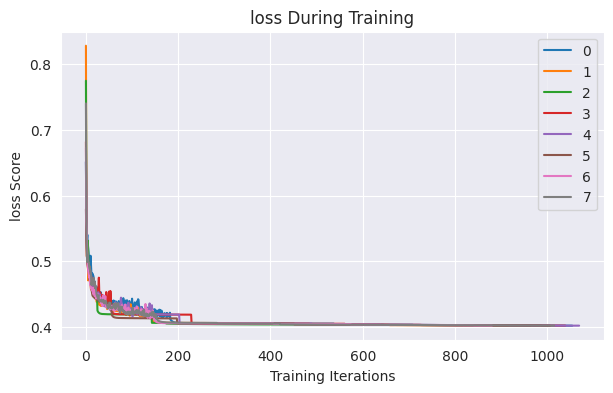

In [46]:
plt.figure(figsize=(7, 4))
for i, df in enumerate(result_dfs):
    plt.plot(df["MSE"], label=i)
plt.legend()
plt.title("MSE During Training")
plt.xlabel("Training Iterations")
plt.ylabel("MSE Score")
plt.show()

In [33]:
for i, df in enumerate(result_dfs):
    print(df["MSE"])

0       0.632389
1       0.529680
2       0.516023
3       0.524322
4       0.509985
          ...   
1050    0.383522
1051    0.383486
1052    0.383518
1053    0.383490
1054    0.383502
Name: MSE, Length: 1055, dtype: float64
0      0.810567
1      0.527594
2      0.491037
3      0.495580
4      0.481445
         ...   
911    0.383687
912    0.383694
913    0.383708
914    0.383675
915    0.383702
Name: MSE, Length: 916, dtype: float64
0      0.760956
1      0.540004
2      0.520835
3      0.487017
4      0.514038
         ...   
959    0.383420
960    0.383434
961    0.383415
962    0.383421
963    0.383434
Name: MSE, Length: 964, dtype: float64
0       0.665623
1       0.540386
2       0.493463
3       0.482290
4       0.477600
          ...   
1035    0.383593
1036    0.383597
1037    0.383573
1038    0.383559
1039    0.383581
Name: MSE, Length: 1040, dtype: float64
0       0.633644
1       0.539807
2       0.503135
3       0.489704
4       0.484369
          ...   
1065    0.3834

In [37]:
model_dict = best_result.checkpoint.to_dict()['model']

In [38]:
model = BetaVAE(config).to(config.device)

In [39]:
model.load_state_dict(model_dict)

<All keys matched successfully>

In [40]:
test(model,X_val_batches)

(0.3834534478688556, -7.3850293643225635, 0.4019160213057462)

In [48]:
torch.save(best_result.checkpoint.to_dict(),'/data/PycharmProjects/cytof_benchmark/logs/ray_tune/Beta_VAE_big.pth')

In [50]:
best_result.metrics['MSE']

0.38341038301239194

In [ ]:
from ray import tune, air
ray.init()

In [5]:
analysis = ray.tune.ExperimentAnalysis(experiment_checkpoint_path='/home/egor/ray_results/vae_training')

2023-01-12 15:42:55,418	INFO experiment_analysis.py:795 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


In [18]:
trial = analysis.get_best_trial(metric="MSE", mode="min")

In [38]:
trial.last_result['training_iteration']

2754

In [35]:
import pickle
with open('/home/egor/ray_results/vae_training/vae_train_a20ab_00014_14_batch_size=10451,learning_rate=0.0000_2023-01-11_15-02-51/checkpoint_tmp8d8afe/.tune_metadata', 'rb') as f:
    metadata = pickle.load(f)

In [37]:
metadata['iteration']

2700

In [45]:
import glob
import os
from ray import tune
from ray.tune.schedulers import PopulationBasedTrainingReplay
# Get a random replay policy from the experiment we just ran
sample_pbt_trial_log = '/home/egor/ray_results/vae_training/pbt_policy_a20ab_00014.txt'
replay = PopulationBasedTrainingReplay(sample_pbt_trial_log)

tuner = tune.Tuner(
    vae_train,
    tune_config=tune.TuneConfig(scheduler=replay),
    run_config=air.RunConfig(stop={"training_iteration": trial.last_result['training_iteration']}),
    param_space={
            "default_config": get_config()
        },
)
results_grid = tuner.fit()

2023-01-12 16:23:10,615	WARNING trial_runner.py:415 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (140 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In this case, consider setting the `TUNE_MAX_PENDING_TRIALS_PG` environment variable to the desired maximum number of concurrent trials.


2023-01-12 16:23:10,622	WARNING pbt.py:1046 -- Trial was initialized with a config, which was overwritten. Did you start the PBT replay with a `config` parameter?
2023-01-12 16:23:12,367	ERROR trial_runner.py:1088 -- Trial vae_train_05f23_00000: Error processing event.
ray.exceptions.RayTaskError(AttributeError): ray::ImplicitFunc.train() (pid=23611, ip=192.168.2.8, repr=vae_train)
  File "/data/PycharmProjects/cytof_benchmark/venv/lib/python3.10/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/data/PycharmProjects/cytof_benchmark/venv/lib/python3.10/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/data/PycharmProjects/cytof_benchmark/venv/lib/python3.10/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_7212/3480078133.py", line 207, in vae_train
  File "/tmp/ipyk

Trial name,date,experiment_id,hostname,node_ip,pid,timestamp,trial_id
vae_train_05f23_00000,2023-01-12_16-23-12,d944b07108304d35aba7cc6ee6caed81,egor-Lambda-Vector,192.168.2.8,23611,1673536992,05f23_00000


2023-01-12 16:23:12,477	ERROR tune.py:758 -- Trials did not complete: [vae_train_05f23_00000]
2023-01-12 16:23:12,477	INFO tune.py:762 -- Total run time: 1.87 seconds (1.75 seconds for the tuning loop).


In [42]:
from typing import List

import numpy as np
import ray
import torch
import torch.optim as optim
from ml_collections import config_dict
from ray import tune, air
from ray.air import session, Checkpoint
from ray.tune.schedulers import PopulationBasedTraining
from torch import nn
from torch.nn import functional as F

from datasets import OrganoidDataset


def get_config():
    config = config_dict.ConfigDict()
    # General parameters
    config.dataset = 'Organoid'
    config.model = 'VAE'
    config.seed = 12345
    config.output_dir = './logs/VanillaVAE/'
    config.device = 'cuda'
    config.epochs = 10000

    # VAE architecture parameters
    config.architecture = config_dict.ConfigDict()
    config.architecture.in_features = 41
    config.architecture.latent_dim = 2
    config.architecture.hidden_dims = [256, 256, 256, 256, 256]
    config.architecture.kld_weight = 0.0025
    config.architecture.loss_type = 'beta'
    config.architecture.activation = 'LeakyReLU'

    # Tunable default parameters
    config.tunable = config_dict.ConfigDict()
    config.tunable.learning_rate = 0.05
    config.tunable.weight_decay = 0.0
    config.tunable.batch_size = 4096
    return config


class BetaVAE(nn.Module):

    def __init__(self, config: config_dict.ConfigDict) -> None:
        super(BetaVAE, self).__init__()

        self.config = config
        self.kld_weight = torch.Tensor([config.architecture.kld_weight]).to(config.device)

        self.act_class = getattr(nn, config.architecture.activation)

        modules = []

        # Build Encoder

        encoder_dims = [config.architecture.in_features] + list(config.architecture.hidden_dims)

        for i in range(len(config.architecture.hidden_dims)):
            modules.append(
                nn.Sequential(
                    nn.Linear(in_features=encoder_dims[i], out_features=encoder_dims[i + 1]),
                    nn.BatchNorm1d(encoder_dims[i + 1]),
                    self.act_class(),
                )
            )
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config.architecture.hidden_dims[-1], config.architecture.latent_dim)
        self.fc_var = nn.Linear(config.architecture.hidden_dims[-1], config.architecture.latent_dim)

        # Build Decoder
        modules = []
        decoder_dims = \
            [config.architecture.latent_dim] + \
            list(reversed(config.architecture.hidden_dims)) + \
            [config.architecture.in_features]

        for i in range(len(config.architecture.hidden_dims) + 1):
            modules.append(
                nn.Sequential(
                    nn.Linear(decoder_dims[i], decoder_dims[i + 1]),
                    nn.BatchNorm1d(decoder_dims[i + 1]),
                    self.act_class()
                )
            )

        self.decoder = nn.Sequential(*modules)
        self.final_layer = nn.Linear(config.architecture.in_features, config.architecture.in_features)

    def encode(self, input: torch.Tensor) -> List[torch.Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """
        Maps the given latent codes
        onto the sample matrix space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C]
        """
        # Only batch - normalized layers
        result = self.decoder(z)
        # Use linear layer to map normalized decoder outputs back to input space
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: torch.Tensor) -> List[torch.Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args) -> dict:
        r"""
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param epoch: current epoch
        :param args:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        recons_loss = F.mse_loss(recons, input)

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim=1), dim=0)

        loss = recons_loss + self.kld_weight * kld_loss

        return {'loss': loss, 'MSE': recons_loss.detach(), 'KLD': -kld_loss.detach()}

    def generate(self, x: torch.Tensor) -> torch.Tensor:
        """
        Given an input sample matrix x, returns the reconstructed sample matrix
        :param x: (Tensor) [B x C]
        :return: (Tensor) [B x C]
        """

        return self.forward(x)[0]

    def latent(self, x: torch.Tensor) -> torch.Tensor:
        return self.reparameterize(*self.encode(x))


def train(model, optimizer, train_dataloader):
    for X_batch in train_dataloader:
        optimizer.zero_grad()
        model.train()
        outputs = model.forward(X_batch)
        loss = model.loss_function(*outputs)

        loss['loss'].backward()
        optimizer.step()


def test(model, val_dataloader):
    with torch.no_grad():
        model.eval()
        mse, kld, loss = list(), list(), list()
        for X_batch in val_dataloader:
            loss_dict = dict()
            outputs = model.forward(X_batch)
            losses = model.loss_function(*outputs)
            for key in losses.keys():
                loss_dict[key] = losses[key].to('cpu').numpy().item() * X_batch.shape[0]
            mse.append(loss_dict['MSE'])
            kld.append(loss_dict['KLD'])
            loss.append(loss_dict['loss'])
    data_len = sum(len(batch) for batch in val_dataloader)

    return \
        np.nan_to_num(sum(mse) / data_len, nan=10), \
        np.nan_to_num(sum(kld) / data_len, nan=10), \
        np.nan_to_num(sum(loss) / data_len, nan=10)


def vae_train(cfg):
    config = cfg.get('default_config')
    model = BetaVAE(config).to(config.device)

    optimizer = optim.Adam(model.parameters(),
                           lr=cfg.get("learning_rate"),
                           )

    dataset = OrganoidDataset(data_dir='/data/organoids')
    X_train, y_train = dataset.train
    X_val, y_val = dataset.val
    X_train_batches = torch.split(X_train, split_size_or_sections=cfg.get("batch_size"))
    X_val_batches = torch.split(X_val, split_size_or_sections=cfg.get("batch_size"))

    # Remove last batch if it has less than half batch size samples to reduce variance
    if X_train_batches[-1].shape[0] < cfg.get("batch_size") // 2:
        X_train_batches = X_train_batches[:-1]

    step = 1
    if session.get_checkpoint():
        checkpoint_dict = session.get_checkpoint().to_dict()

        model.load_state_dict(checkpoint_dict["model"])
        optimizer.load_state_dict(checkpoint_dict["optim"])
        # Note: Make sure to increment the loaded step by 1 to get the
        # current step.
        last_step = checkpoint_dict["step"]
        step = last_step + 1

        # NOTE: It's important to set the optimizer learning rates
        # again, since we want to explore the parameters passed in by PBT.
        # Without this, we would continue using the exact same
        # configuration as the trial whose checkpoint we are exploiting.
        if "learning_rate" in cfg:
            for param_group in optimizer.param_groups:
                param_group["lr"] = cfg["learning_rate"]
    while True:
        train(model, optimizer, X_train_batches)
        MSE, KLD, loss = test(model, X_val_batches)

        checkpoint = None
        if step % cfg["checkpoint_interval"] == 0:
            checkpoint = Checkpoint.from_dict(
                {
                    "model": model.state_dict(),
                    "optim": optimizer.state_dict(),
                    "step": step,
                }
            )
        session.report(
            {
                "MSE": MSE,
                "KLD": KLD,
                "loss": loss,
                'lr': cfg.get("learning_rate"),
                "step": step,
            },
            checkpoint=checkpoint,
        )
        step += 1